# Ciclope example 03 - tooth compression test
This notebook is still under preparation.

### - 3D tetrahedra-FE from CT scan
### - Tooth embedding and steel caps
### - FE model solution in Calculix

Created on:  30.04.2022 <br />
Last update: 30.04.2022 <br />

- Data courtesy of ...

For info on the solver see the [Calculix homepage](http://www.calculix.de/)

## Configuration

In [1]:
import sys
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

In [2]:
# import os
import numpy as np
# import dxchange
import matplotlib
import matplotlib.pyplot as plt

# import mcubes
from scipy import ndimage
from skimage.filters import threshold_otsu, threshold_multiotsu
from skimage import morphology # measure
import skimage.io as skio

from recon_utils import plot_midplanes, bbox # read_tiff_stack
from pybonemorph import fill_voids, embed
import ciclope

astropy module not found


In [3]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

#### Load input data

In [4]:
# input_file = '/home/gianthk/Data/sarig/Tooth_TAU_3_scaled.tif'
input_file = '/home/gianthk/Data/sarig/Tooth_TAU_3_scaled_2.tif' # scale factor: 0.4

In [5]:
data_3D = skio.imread(input_file, plugin="tifffile")
vs = np.ones(3)*16.5e-3/0.4 # [mm]

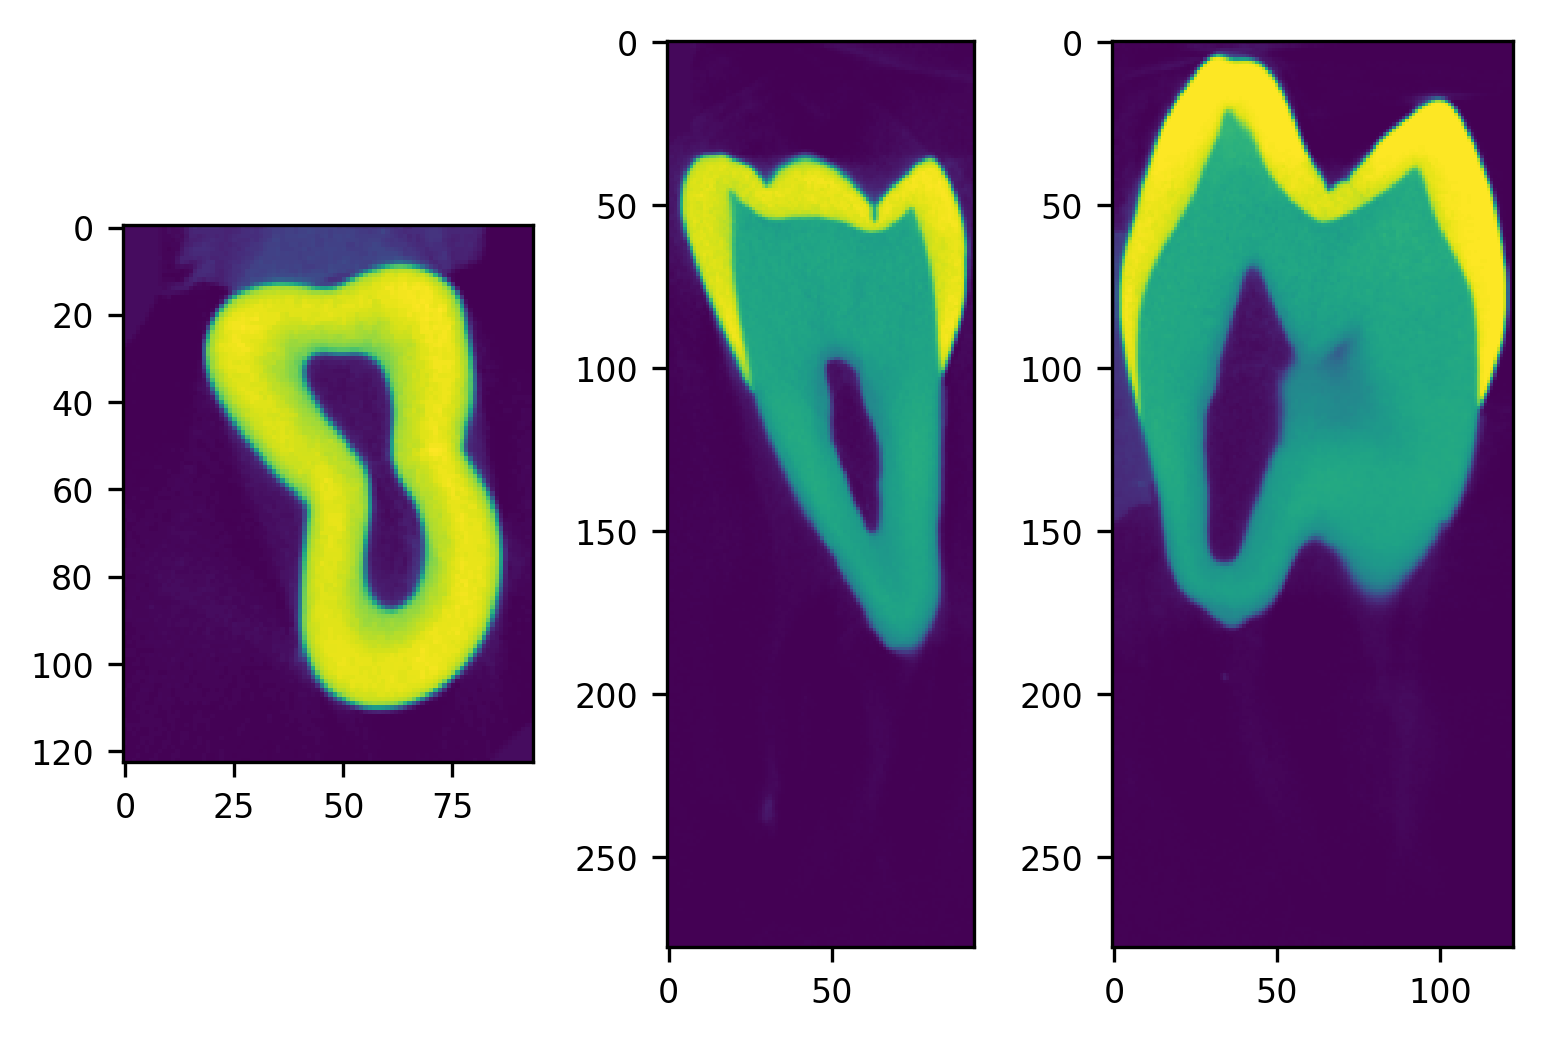

In [7]:
# Inspect dataset
plot_midplanes(data_3D)

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [6]:
# import itk
# from itkwidgets import view
# viewer = view(data_3D, ui_collapsed=True)
# viewer.interpolation = False

In [ ]:
# # launch itk viewer
# viewer

## Pre-processing
### Resize (don't)

In [48]:
# resampling = 2.0

# # resize the 3D data using spline interpolation of order 2
# data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# # correct voxelsize
# vs = vs * resampling

### Thresholding

In [6]:
# use Multi-Otsu's method
Ts = threshold_multiotsu(data_3D)
print("Thresholds: {}".format(Ts))

Thresholds: [ 73 193]


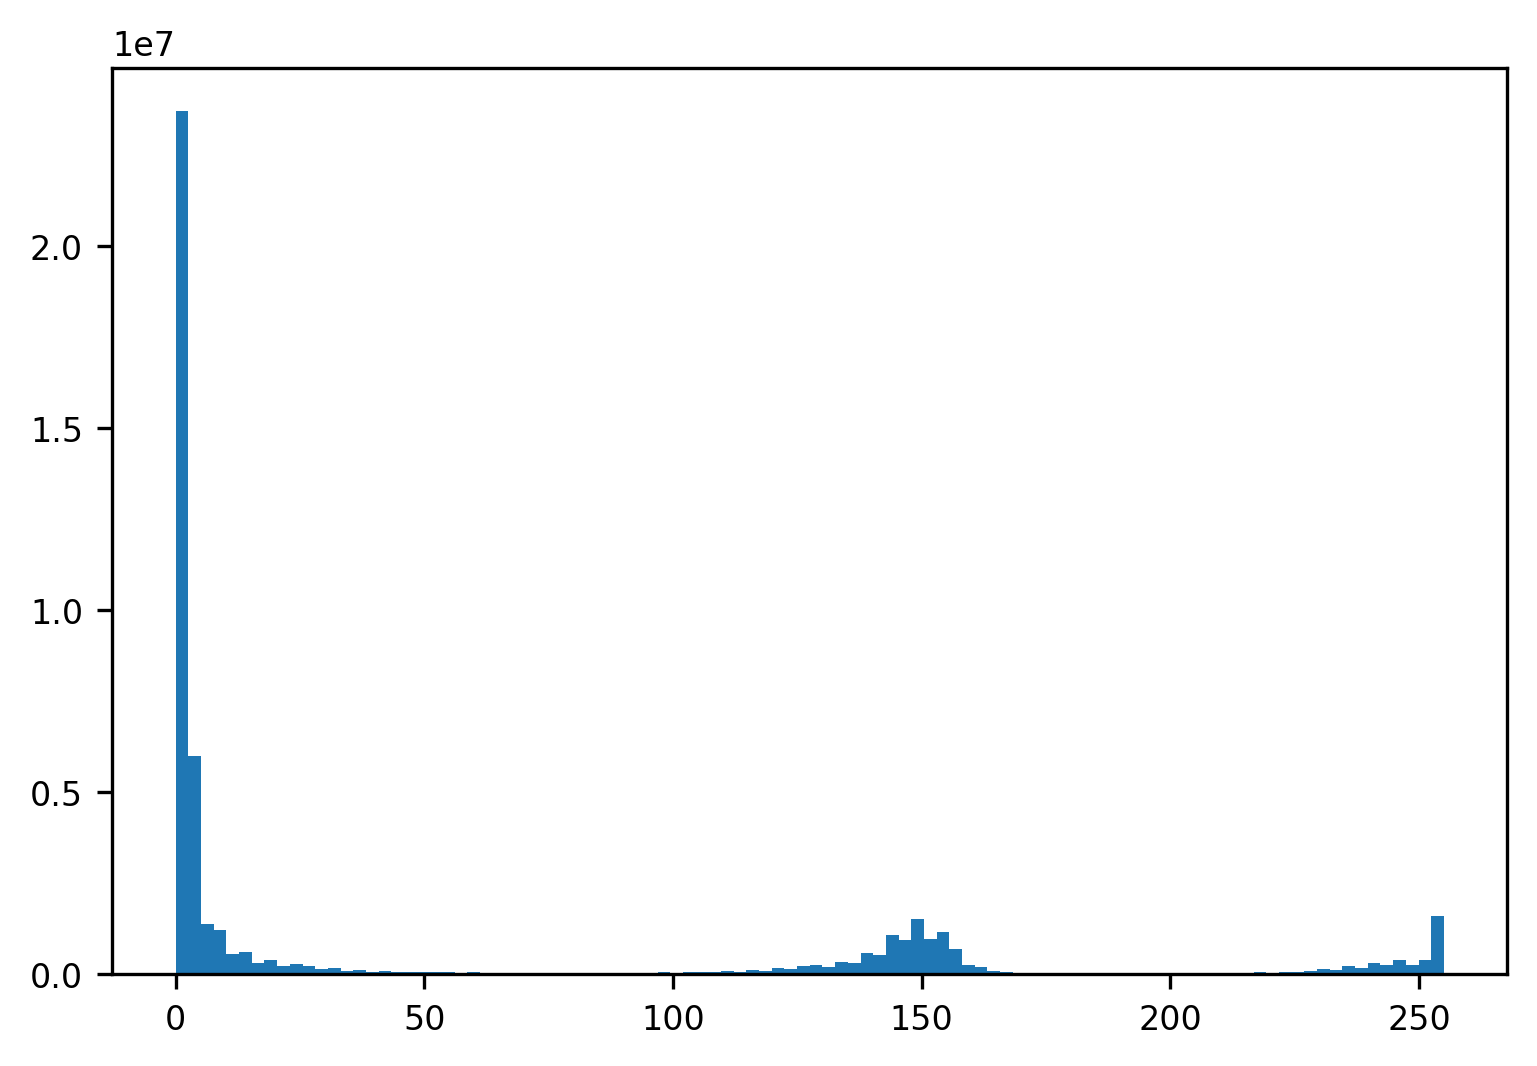

In [16]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=100)
plt.show()

Apply the thrsholds

In [7]:
# BW_tooth = np.ma.masked_greater_equal(data_3D, Ts[0])
BW_tooth = data_3D >= Ts[0]

In [8]:
# BW_dentin = np.ma.masked_inside(data_3D, Ts[0], Ts[1])
BW_dentin = (data_3D <= Ts[1]) & (data_3D >= Ts[0])

In [9]:
# BW_enamel = np.ma.masked_greater(data_3D, Ts[1])
BW_enamel = data_3D > Ts[1]

### Morphological open and fill holes within dentin mask

In [10]:
BW_dentin = ndimage.binary_fill_holes(ndimage.binary_opening(BW_dentin, morphology.ball(3)))

In [11]:
BW_tooth = ndimage.binary_fill_holes(ndimage.binary_opening(BW_tooth, morphology.ball(3)))

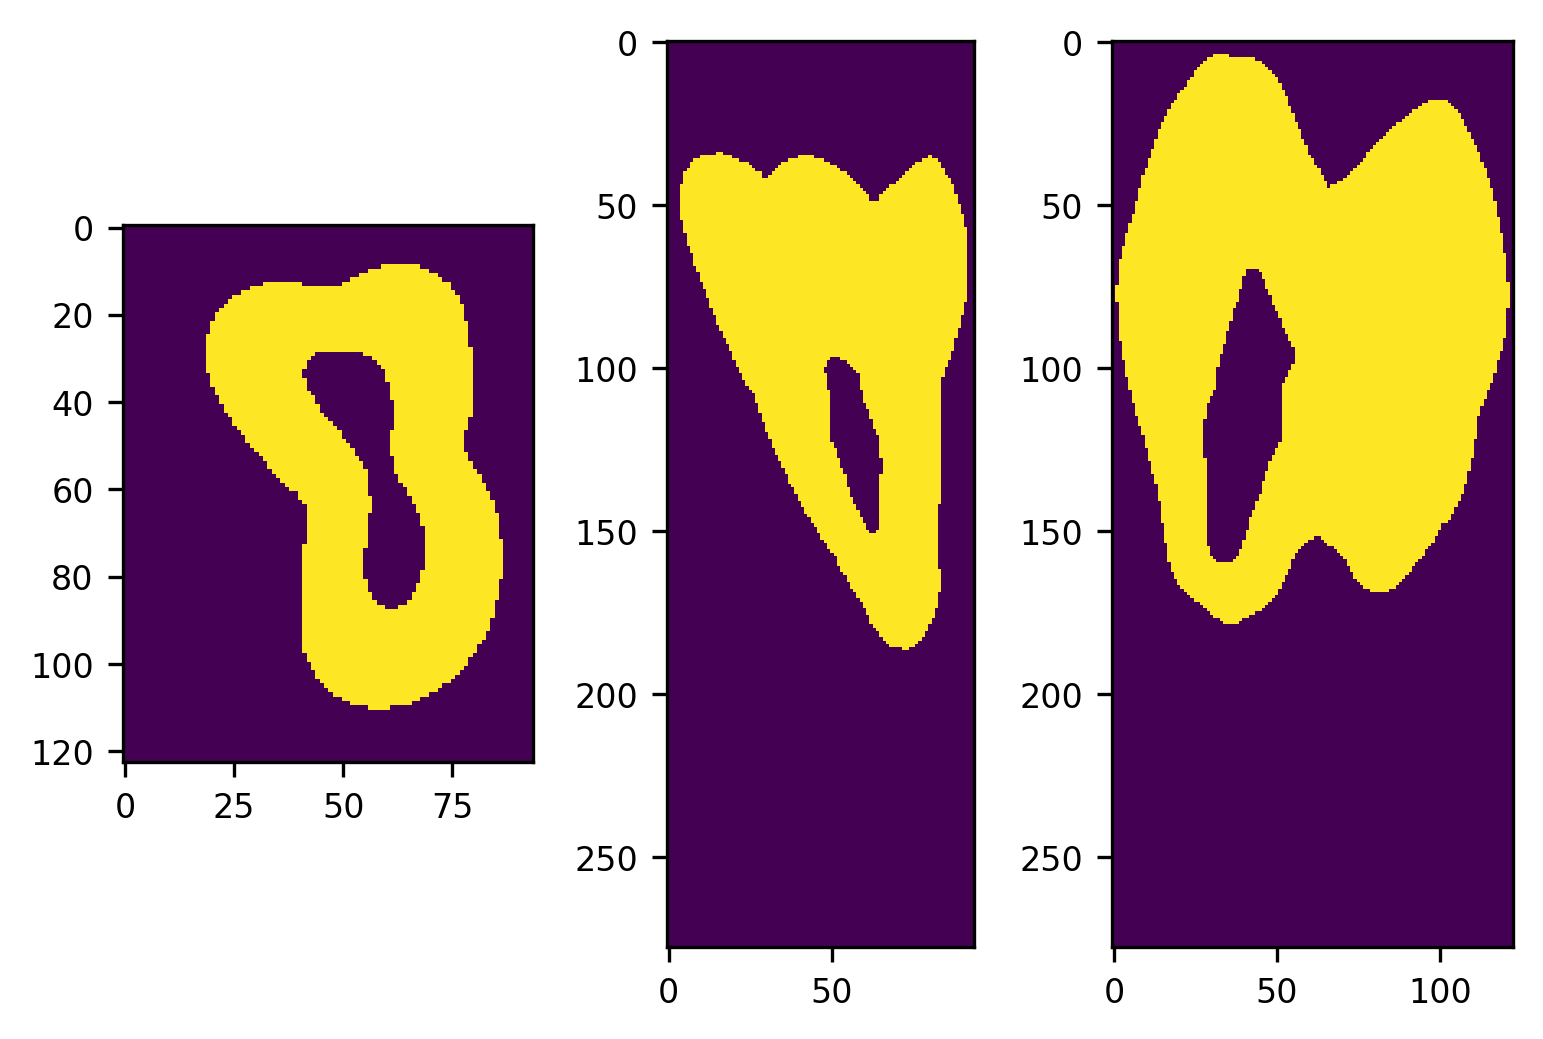

In [79]:
plot_midplanes(BW_tooth)

# Create color image with different materials
1. dentin
2. enamel
3. cement embedding

In [12]:
# data_for_meshing = BW_dentin*1 + BW_enamel.mask*2 + BW_embedding*3
data_for_meshing = fill_voids(BW_dentin*1 + BW_enamel*2, 1, False)

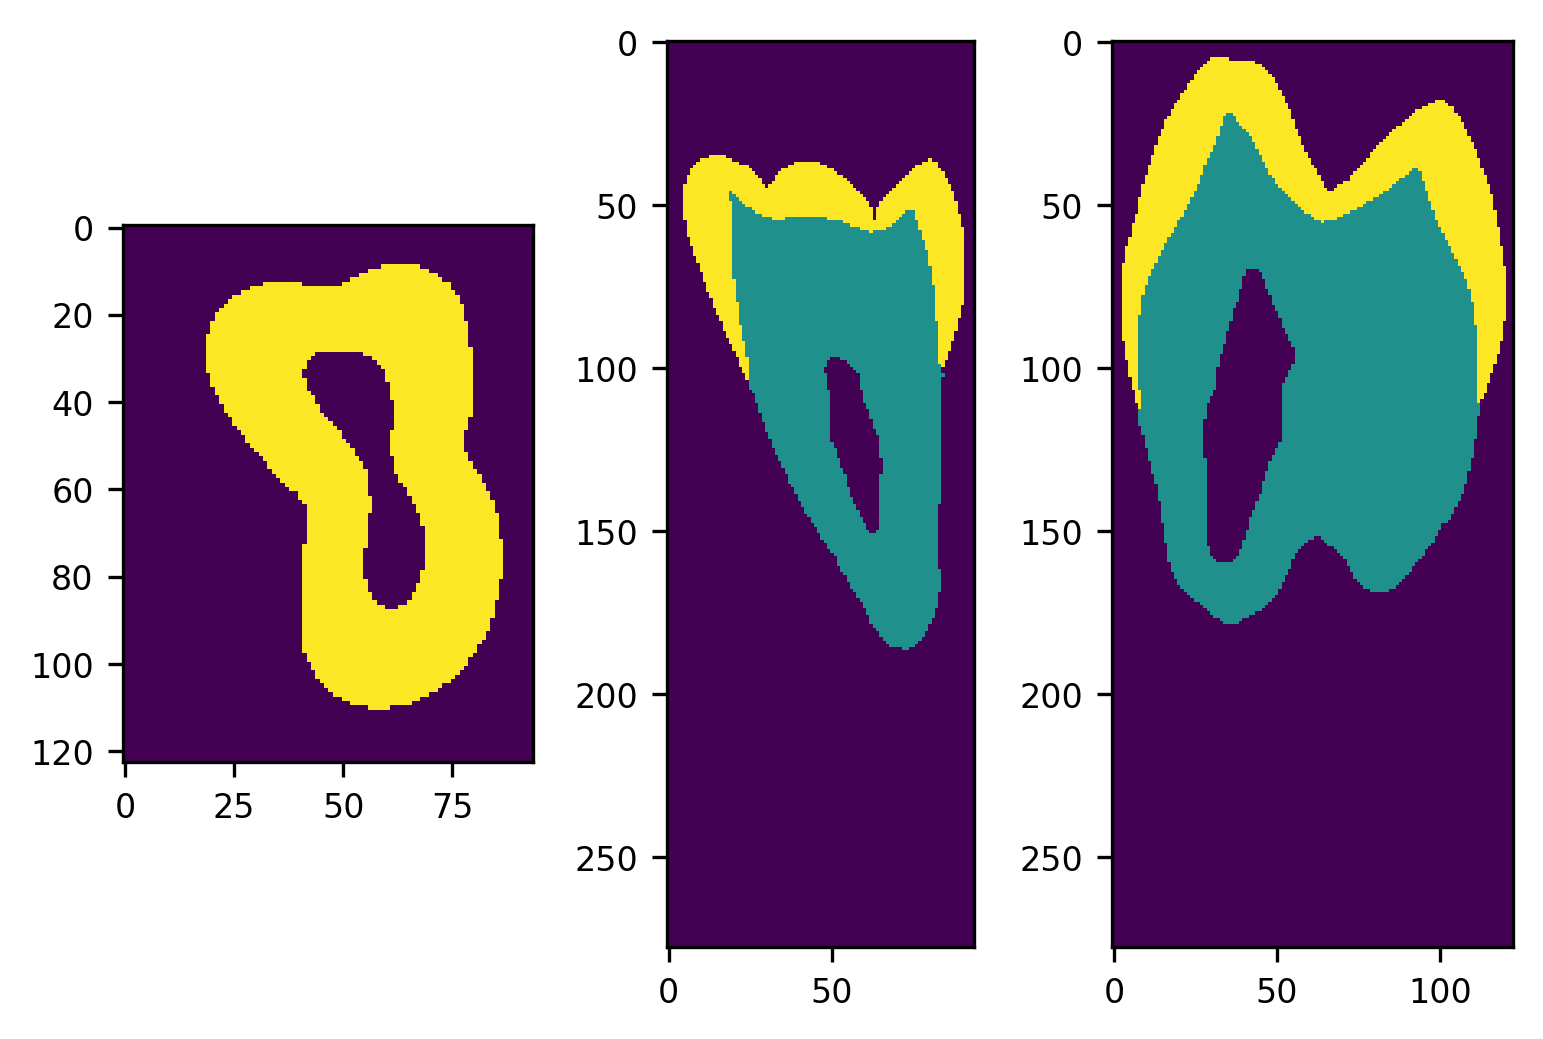

In [14]:
plot_midplanes(data_for_meshing)

# Embed tooth from top and bottom

In [13]:
data_for_meshing_embedded, BW_embedding_bottom = embed(data_for_meshing, 140, "-z", embed_val=3, pad=2, makecopy=True)
data_for_meshing_embedded, BW_embedding_top = embed(data_for_meshing_embedded, 40, "+z", embed_val=3, pad=2)

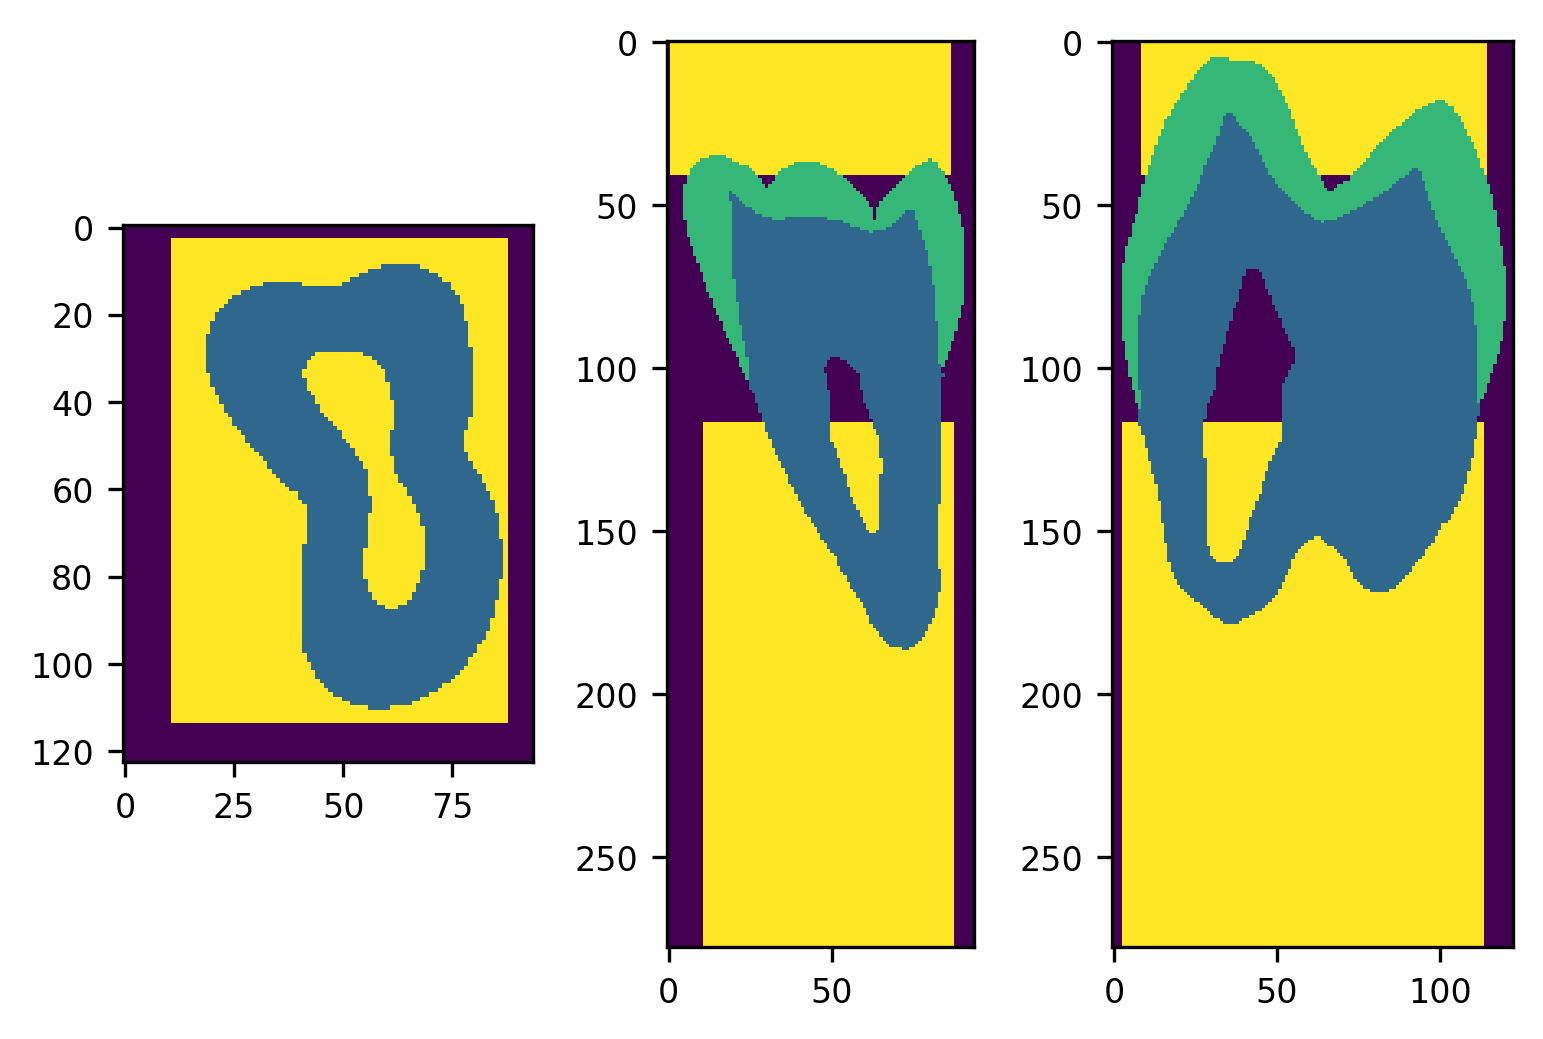

In [14]:
plot_midplanes(data_for_meshing_embedded)

## Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [15]:
filename_mesh_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/tooth/pippo.vtk'

In [16]:
import pygalmesh

In [21]:
5*1.2*min(vs)

0.2475

In [25]:
# mesh = pygalmesh.generate_from_array(np.transpose(data_for_meshing_embedded, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))
mesh = pygalmesh.generate_from_array(np.transpose(data_for_meshing_embedded, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))

In [44]:
min(mesh.cell_data['medit:ref'][1])

1

In [49]:
mesh

<meshio mesh object>
  Number of points: 10630
  Number of cells:
    triangle: 26192
    tetra: 53327
  Point data: medit:ref
  Cell data: medit:ref

In [41]:
mesh.cells

[<meshio CellBlock, type: triangle, num cells: 26192>,
 <meshio CellBlock, type: tetra, num cells: 53327>]

Find indexes of cells with `medit:ref` scalar = 1

In [56]:
idx_1 = np.where(mesh.cell_data['medit:ref'][1] == 1)
idx_2 = np.where(mesh.cell_data['medit:ref'][1] == 2)
idx_3 = np.where(mesh.cell_data['medit:ref'][1] == 3)

In [66]:
np.unique(mesh.cell_data['medit:ref'][1])

array([1, 2, 3])

In [69]:
hasattr(mesh, 'cell_data')

True

In [81]:
np.where(mesh.cell_data['medit:ref'][1] == 1)[0]

array([    1,     4,    10, ..., 53322, 53325, 53326])

Alternatively use the method `ciclope.cgal_mesh`

In [21]:
mesh = ciclope.tetraFE.cgal_mesh(data_for_meshing_embedded, vs, 'tetra', 1.2*min(vs), 5*1.2*min(vs))

construct initial points (nb_points: 12)
12/12 initial point(s) found...
Start surface scan...Scanning triangulation for bad facets (sequential) - number of finite facets = 51...
Number of bad facets: 21
scanning edges (lazy)
scanning vertices (lazy)
end scan. [Bad facets:21]

Refining Surface...
Legend of the following line: (#vertices,#steps,#facets to refine,#tets to refine)
(1276,1263,714,0) (21300.3 vertices/s)

KeyboardInterrupt: 

In [96]:
mesh.write(filename_mesh_out)

---
# Embedding from bottom explained

1. Get max X-projection until desired depth

In [42]:
embed_depth = 380 # [pixels]

In [43]:
embed_axis = "z"
embed_dir = -1

In [44]:
BW_dentin.shape

(695, 308, 236)

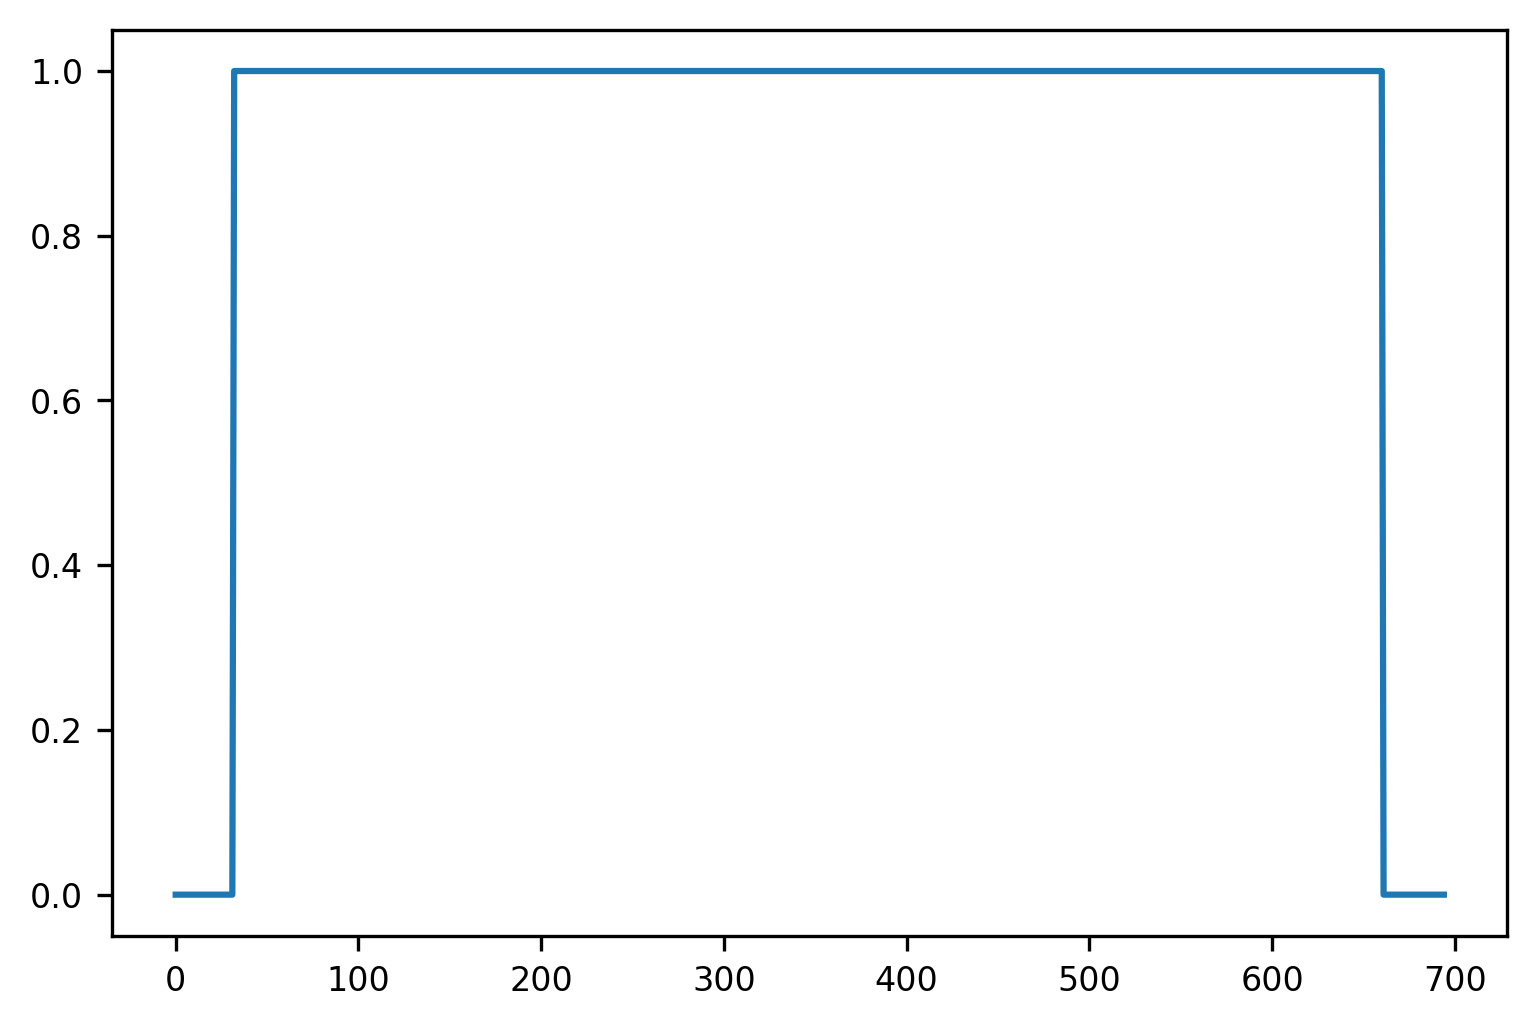

In [46]:
plt.plot(np.max(BW_dentin.max(1), 1))

In [47]:
embed_start = np.where(np.max(BW_dentin.max(1), 1) == True)[-1][-1]

### Get bounding box for embedding
Z-max-projection of embedded region

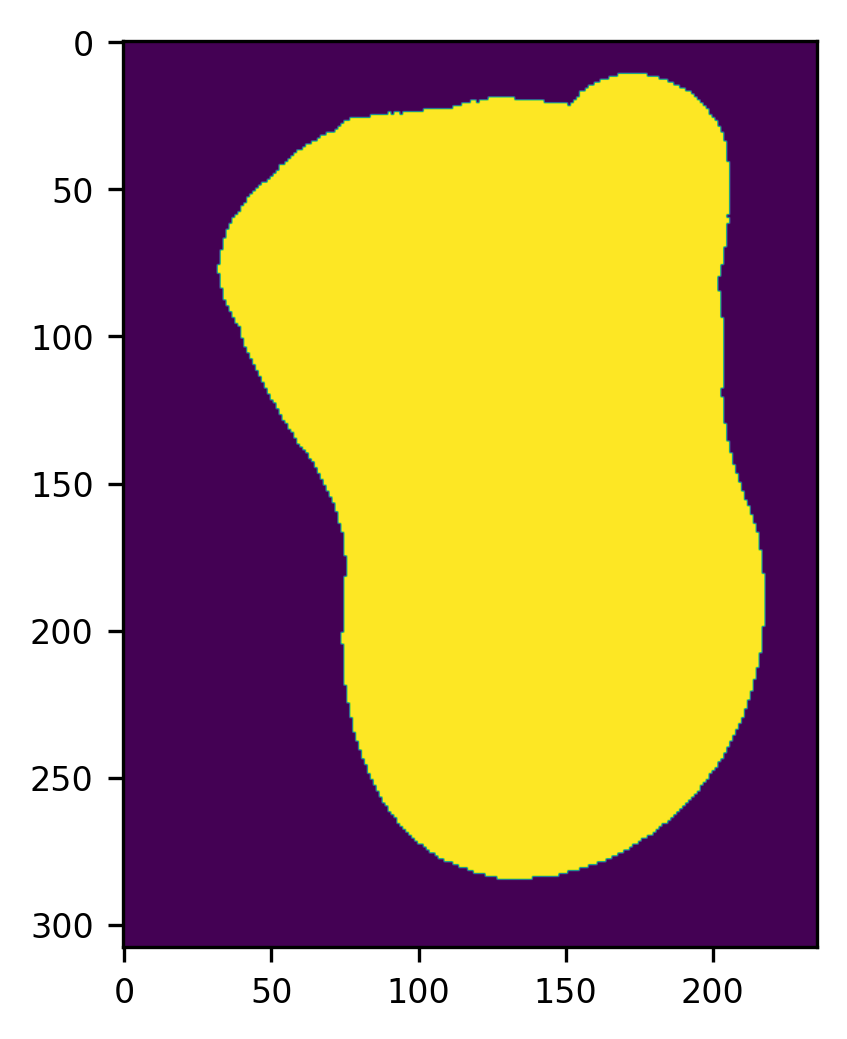

In [49]:
plt.imshow(BW_dentin[embed_start + (embed_dir*embed_depth):,:,:].max(0))

In [52]:
# bbox_origin, bbox_size = bbox(BW_dentin[embed_start + (embed_dir*embed_depth):,:,:], 2)
bbox_origin, bbox_size = bbox(BW_dentin[embed_start + (embed_dir*embed_depth):,:,:])

In [64]:
BW_embedding = np.ma.array(data_3D, mask=False)

In [54]:
BW_embedding.shape

(695, 308, 236)

In [65]:
BW_embedding[embed_start + (embed_dir*embed_depth):, bbox_origin[0]:bbox_origin[0]+bbox_size[0], bbox_origin[1]:bbox_origin[1]+bbox_size[1]] = np.ma.masked

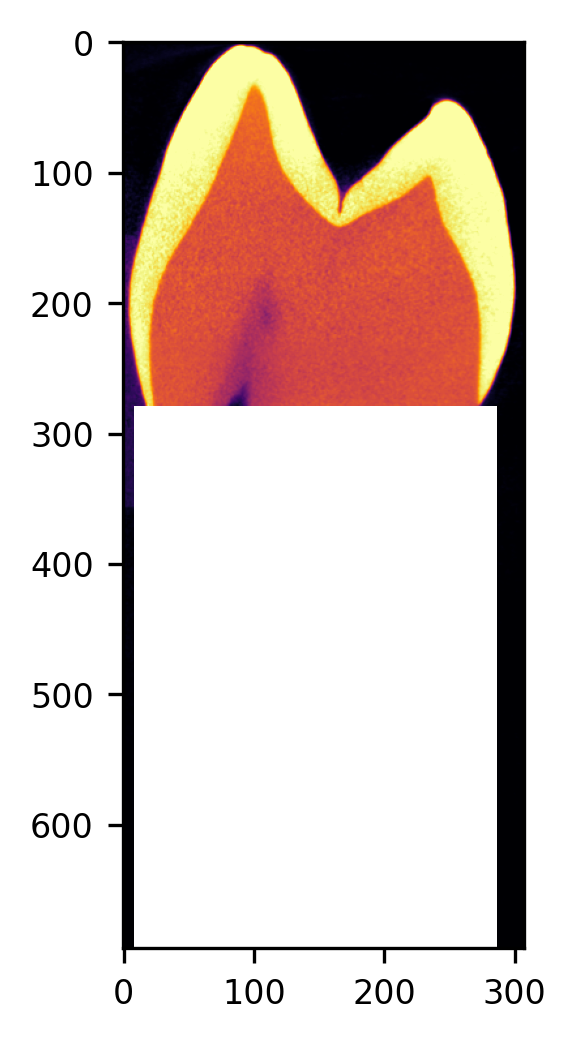

In [66]:
plt.imshow(BW_embedding[:,:,100], cmap='inferno')

In [62]:
from pybonemorph import remove_unconnected

In [67]:
# BW_embedding[BW_tooth.mask==True] = np.ma.nomask
# BW_embedding = BW_embedding.mask & ~BW_tooth
BW_embedding = remove_unconnected(BW_embedding.mask & ~BW_tooth)

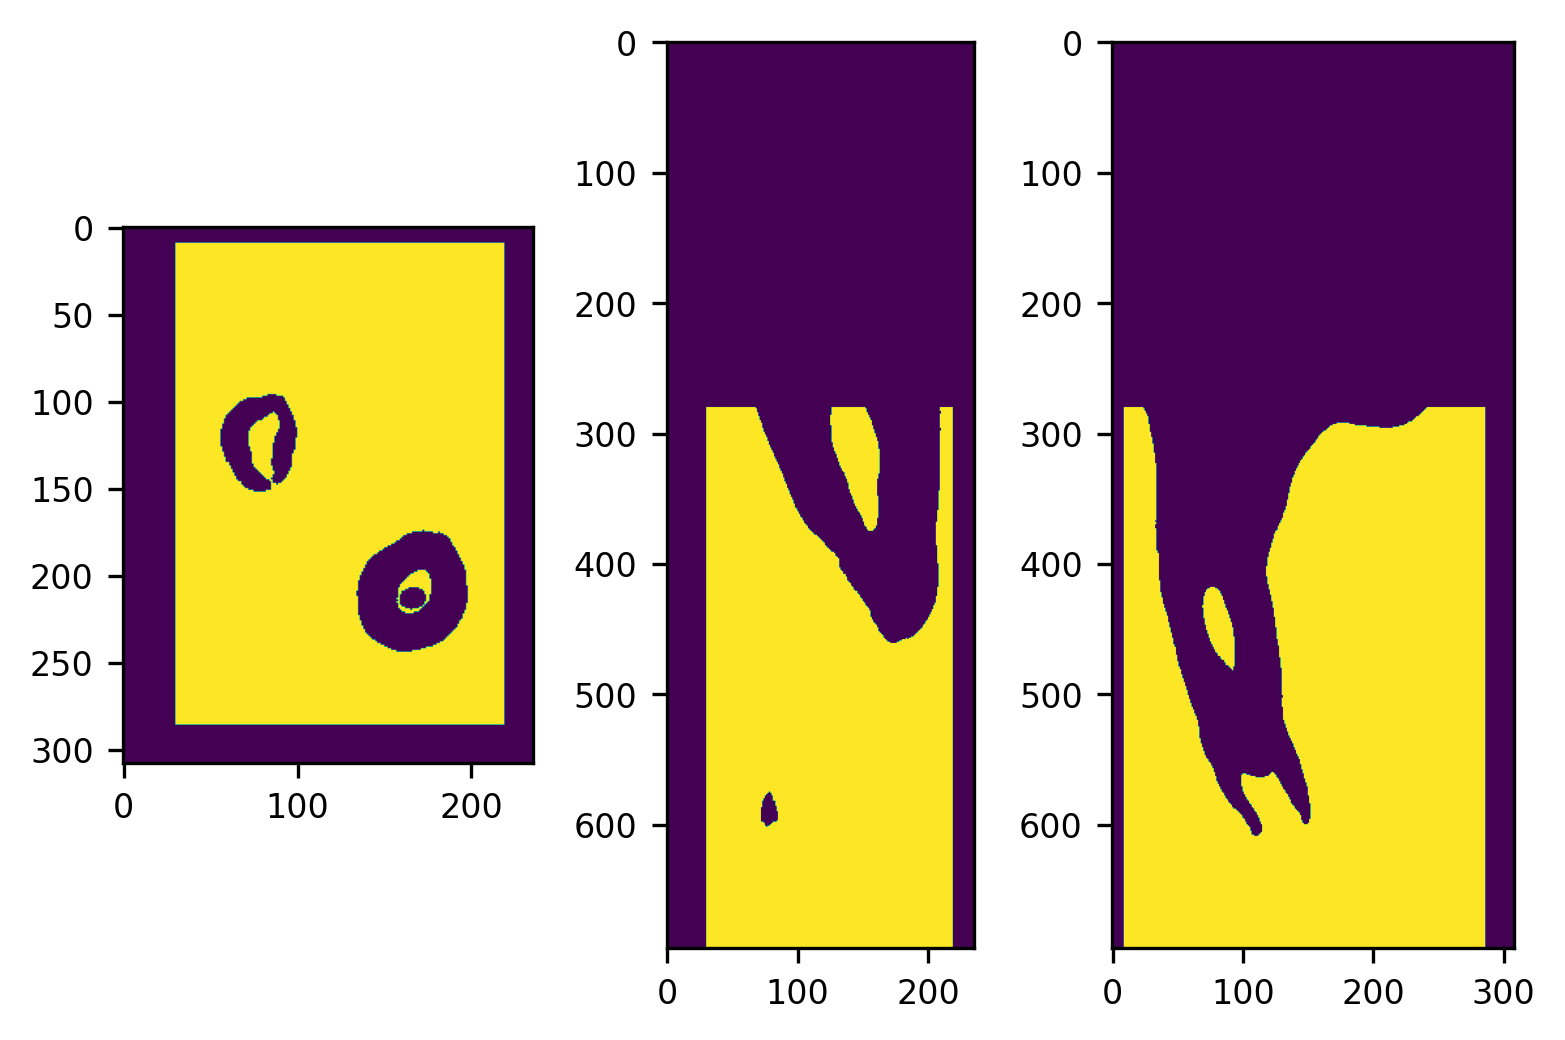

In [75]:
plot_midplanes(BW_embedding, 150, 80, 590)

## Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [79]:
filename_mesh_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/tooth/pippo.vtk'

In [74]:
import pygalmesh
mesh = pygalmesh.generate_from_array(np.transpose(L, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))

Alternatively use the method `ciclope.cgal_mesh`

In [ ]:
mesh = ciclope.tetraFE.cgal_mesh(data_for_meshing, vs, 'tetra', 1.2*min(vs), 5*1.2*min(vs))

In [96]:
mesh.write(filename_mesh_out)

Visualize the mesh with itkwidgtes

In [97]:
import vtk
import itk
from itkwidgets import view

In [98]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_mesh_out)
reader.Update()
grid = reader.GetOutput()

In [ ]:
view(geometries=grid)

## Write Abaqus input FE files
### Generate tetrahedra-FE model with constant material properties
The method `ciclope.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

In [10]:
input_template = "./../input_templates/tmp_example02_tens_static_steel.inp"

Inspect input template file

In [11]:
!cat {input_template}

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=STEEL_4301
*ELASTIC
210000, 0.3333333333, 0
*DENSITY
7.85e-9
*SOLID SECTION, ELSET=SET1, MATERIAL=STEEL_4301
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_B, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_T, 3, 3, +0.1
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_B
RF
*EL FILE, OUTPUT=2D
S
*END STEP


In [12]:
filename_out = './../test_data/steel_foam/B_matrix_tetraFE.inp'

Generate CalculiX FE input file

In [102]:
ciclope.mesh2tetrafe(mesh, input_template, filename_out, keywords=['NSET', 'ELSET'])

INFO:root:Converting mesh with fields:

INFO:root:{'points': array([[ 1.0637777e-01,  2.7099030e+00,  1.2464654e+00],
       [ 3.1638098e+00,  2.4738045e+00,  8.2634044e-01],
       [-2.8007149e-04,  2.4925890e+00,  1.6835400e+00],
       ...,
       [ 1.7855428e+00,  3.3190203e+00,  1.1995814e+00],
       [ 6.9351017e-01,  3.2858081e+00,  2.6503036e+00],
       [ 2.7904041e+00,  2.9363434e+00,  2.7100861e+00]], dtype=float32), 'cells': [<meshio CellBlock, type: tetra, num cells: 122964>], 'point_data': {'medit:ref': array([1, 1, 1, ..., 1, 1, 1])}, 'cell_data': {'medit:ref': array([1, 1, 1, ..., 1, 1, 1])}, 'field_data': {}, 'point_sets': {}, 'cell_sets': {}, 'gmsh_periodic': None, 'info': None}
INFO:root:Reading Abaqus template file input_templates/tmp_example02_tens_static_steel.inp
INFO:root:Data written to file /home/gianthk/PycharmProjects/CT2FE/test_data/steel_foam/B_matrix_tetraFE.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [263]:
# !export OMP_NUM_THREADS=8; ccx_2.17_MT "trabecular_sample_voxelfe"

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [103]:
import ccx2paraview

In [ ]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

#### Visualize results in Paraview

In [65]:
!paraview filename_out_base + '.vtk'

![](./../test_data/steel_foam/B_matrix_tetraFE_Smises.png)

### Generate tetrahedra-FE model for non-linear analysis

In [2]:
input_template = "./../input_templates/tmp_example02_tens_Nlgeom_steel.inp"

Inspect .INP template file for non-linear analysis

In [3]:
!cat {input_template}

** -----------------`----------------------------------
** Material definition:
*MATERIAL, NAME=STEEL_4301
*ELASTIC
210000, 0.3333333333, 0
*DENSITY
7.85e-9
*PLASTIC
2000, 0, 0
3000, 1, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=STEEL_4301
** ---------------------------------------------------
** Analysis definition:
*TIME POINTS, NAME=t10, GENERATE
0, 1, 0.05
*STEP, AMPLITUDE=RAMP, UNSYMM=YES, NLGEOM=YES
*STATIC
0.2, 1, 1e-04, 0.2
** All displacements fixed at bottom:
*BOUNDARY, TYPE=DISPLACEMENT
NODES_B, 1, 3, 0
** Vertical displacement imposed at top:
*BOUNDARY, TYPE=DISPLACEMENT
NODES_T, 3, 3, +0.5
** ---------------------------------------------------
** Output request:
*EL FILE, OUTPUT=2D, TIME POINTS=t10
S,PEEQ
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_B
RF
*END STEP


In [15]:
filename_out = './../test_data/steel_foam/B_matrix_tetraFE_Nlgeom.inp'

In [ ]:
ciclope.mesh2tetrafe(mesh, input_template, filename_out, keywords=['NSET', 'ELSET'])

Generate CalculiX FE input file

In [110]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading B_matrix_tetraFE_Nlgeom.frd
INFO:root:38341 nodes
INFO:root:122964 cells
INFO:root:Step 1, time 5.00e-02, U, 3 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S, 6 components, 38341 values
INFO:root:Step 1, time 5.00e-02, PEEQ, 1 components, 38341 values
INFO:root:Step 1, time 5.00e-02, ERROR, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, U, 3 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S, 6 components, 38341 values
INFO:root:Step 2, time 1.00e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, ERROR, 1 components, 38341 values
INFO:root:Step 3, time 1.50e-01, U, 3 components, 38341 values
INFO:root:Step 3, time 1.50e-01, S, 6 components, 38341 values
INFO:root:Step 3, time 1.50e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 3, time 1.50e-01, ERROR, 1 components, 38341 values
INFO:root:Step 4, time 2.00e-01, U, 3 components, 38341 values
INFO:root:Step 4, time 2.00e-01, S, 6 components, 38341 values
INFO:r

INFO:root:Step 1, time 5.00e-02, U, 3 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S, 6 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S_Mises, 1 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S_Principal, 3 components, 38341 values
INFO:root:Step 1, time 5.00e-02, PEEQ, 1 components, 38341 values
INFO:root:Step 1, time 5.00e-02, ERROR, 1 components, 38341 values
INFO:root:Writing B_matrix_tetraFE_Nlgeom.02.vtk
INFO:root:Step 2, time 1.00e-01, U, 3 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S, 6 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S_Mises, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S_Principal, 3 components, 38341 values
INFO:root:Step 2, time 1.00e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, ERROR, 1 components, 38341 values
INFO:root:Writing B_matrix_tetraFE_Nlgeom.03.vtk
INFO:root:Step 3, time 1.50e-01, U, 3 components, 38341 values
INFO:root:Step 3, time 1.50e-01, S, 6

INFO:root:Step 19, time 9.50e-01, S, 6 components, 38341 values
INFO:root:Step 19, time 9.50e-01, S_Mises, 1 components, 38341 values
INFO:root:Step 19, time 9.50e-01, S_Principal, 3 components, 38341 values
INFO:root:Step 19, time 9.50e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 19, time 9.50e-01, ERROR, 1 components, 38341 values
INFO:root:Writing B_matrix_tetraFE_Nlgeom.20.vtk
INFO:root:Step 20, time 1.0, U, 3 components, 38341 values
INFO:root:Step 20, time 1.0, S, 6 components, 38341 values
INFO:root:Step 20, time 1.0, S_Mises, 1 components, 38341 values
INFO:root:Step 20, time 1.0, S_Principal, 3 components, 38341 values
INFO:root:Step 20, time 1.0, PEEQ, 1 components, 38341 values
INFO:root:Step 20, time 1.0, ERROR, 1 components, 38341 values


Equivalent Plastic Strain (PEEQ) animation created in Paraview:
![](test_data/steel_foam/B_matrix_tetraFE_Nlgeom_results/PEEQ.gif)

#### Post-process FE analysis results
We use the helper script `dat2txt.py` from Martin Kraska to clean and convert the CalculiX FE output `.DAT` file to a text file containing only data:

In [1]:
import dat2txt

In [16]:
filename_dat = './../test_data/steel_foam/B_matrix_tetraFE_Nlgeom.dat'

In [3]:
dat2txt.dat2txt(filename_dat, True)

INFO:root:Reading file /home/gianthk/PycharmProjects/CT2FE/test_data/steel_foam/B_matrix_tetraFE_Nlgeom.dat.
INFO:root:Written total force fx,fy,fz for group NODES_B to file: total force fx,fy,fz_NODES_B.txt.
Total time points: 59.



('total force fx,fy,fz', 'NODES_B', 59)

Load and plot results with pandas

In [18]:
import pandas as pd

In [12]:
%matplotlib inline

In [19]:
header = ['time', 'fx', 'fy', 'fz']
filename_txt = './../test_data/steel_foam/total force fx,fy,fz_NODES_B.txt'
data = pd.read_table(filename_txt, delim_whitespace=True, names=header, index_col=0)

Have a look at the data produced by CalculiX

In [20]:
data

,fx,fy,fz
time,,,
0.05,6.246617e-09,-9.647296e-10,-63.92774
0.10,1.269526e-10,2.538340e-10,-97.62540
0.15,3.104711e-09,1.066627e-09,-116.32770
0.20,9.618676e-10,-4.711595e-10,-129.88530
0.25,-4.597598e-07,-8.556020e-08,-141.77580
0.30,3.020426e-07,3.076565e-07,-152.58380
0.35,-4.586224e-09,1.690051e-08,-161.88950
0.40,1.673068e-09,2.573413e-09,-168.59850
0.45,3.774273e-07,1.899347e-07,-174.08460


Plot Force-Displacement curve

Text(0, 0.5, 'Total force Fz')

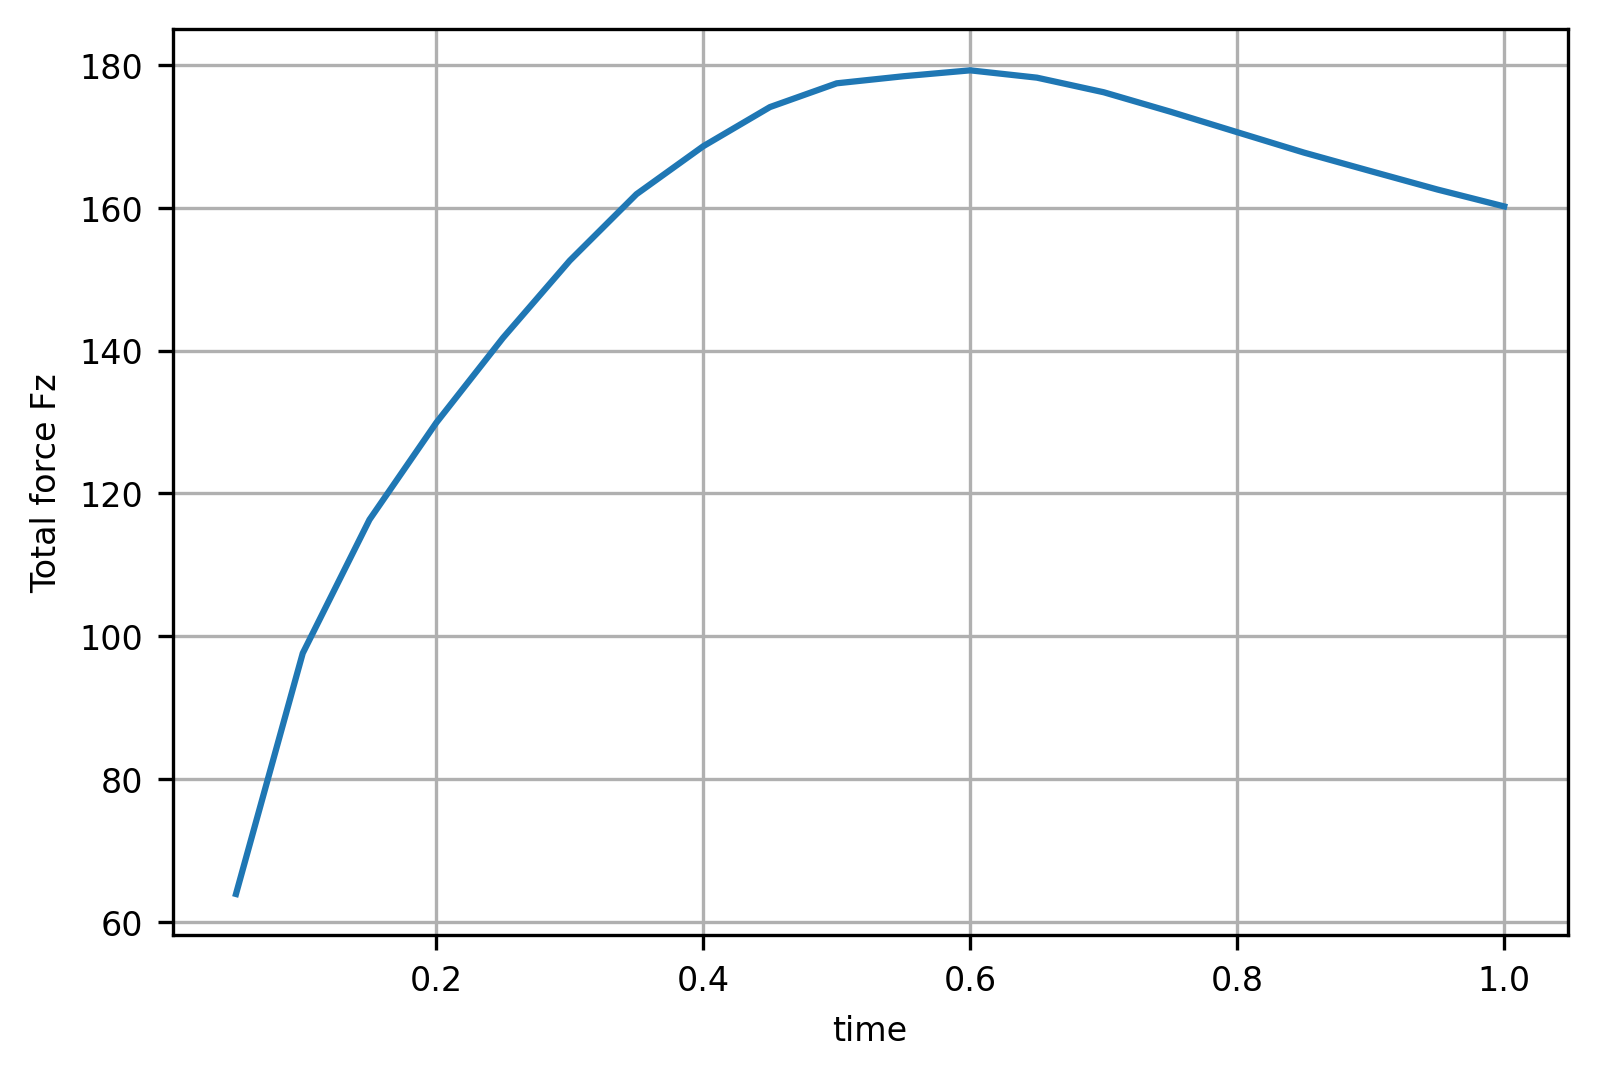

In [32]:
fig, axs = plt.subplots()

data['fz'].abs().plot(ax=axs, grid=True)
axs.set_ylabel("Total force Fz")

# fig.savefig("no2_concentrations.png")